# My Lecture 3

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

# Some additional libraries which we'll use just
# to produce some visualizations of our training
from libs.utils import montage
from libs import gif

import IPython.display as ipyd
plt.style.use('ggplot')

# Bit of formatting because I don't like the default inline code style:
from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 4px;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
} </style>""")

## Load dataset

In [2]:
from libs.datasets import MNIST
ds = MNIST()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
print([x for x in dir(ds) if '__' not in x])

['X', 'Y', 'all_idxs', 'all_inputs', 'all_labels', 'mean', 'n_labels', 'split', 'std', 'test', 'test_idxs', 'train', 'train_idxs', 'valid', 'valid_idxs']


In [11]:
print(ds.X.shape)

(70000, 784)


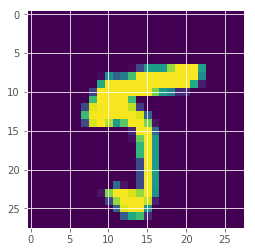

In [12]:
plt.imshow(ds.X[0].reshape((28,28)))

## Processing

In [13]:
mean_img = ds.X.mean(axis=0)

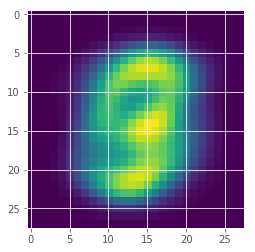

In [14]:
plt.imshow(mean_img.reshape((28,28)))

In [15]:
std_img = ds.X.std(axis=0)

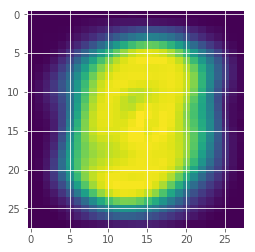

In [16]:
plt.imshow(std_img.reshape(28,28))

# Autoencoder

In [17]:
output_dimensions = [512, 256, 128, 64]

In [18]:
nb_features = ds.X.shape[1]

In [19]:
nb_features

784

In [20]:
X = tf.placeholder(tf.float32, [None, nb_features])

## Build encoder

In [21]:
current_input = X
nb_current_features = nb_features

Network = []

for i, nb_current_output in enumerate(output_dimensions):
    with tf.variable_scope("encoder/layer/{}".format(i)):
        W = tf.get_variable(name='W', shape=[nb_current_features, nb_current_output], 
                            initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))
        h = tf.matmul(current_input, W)
        current_input = tf.nn.relu(h)
        
        Network.append(W)
        nb_current_features = nb_current_output

In [15]:
print(current_input.shape)

(?, 64)


## Build decoder

In [16]:
# Reverse the Network
Network = Network[::-1]
# Reverse and add original dimensions 
output_dimensions = output_dimensions[::-1][1:] + [ds.X.shape[1]]
print(output_dimensions)

[128, 256, 512, 784]


In [17]:
for i, nb_current_output in enumerate(output_dimensions):
    with tf.variable_scope("decoder/layer/{}".format(i)):
        W = tf.transpose(Network[i])
        h = tf.matmul(current_input, W)

        current_input = tf.nn.relu(h)
        
#         nb_current_features = nb_current_output

In [18]:
# And now we have the output of the network
Y = current_input

## Cost

In [19]:
# Average cost against every pixel
cost = tf.reduce_mean(tf.squared_difference(X, Y), 1)
print(cost.shape)

(?,)


In [20]:
# And average that across batches
cost = tf.reduce_mean(cost)

## Training

In [21]:
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [22]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [23]:
batch_size = 100
nb_epochs = 5

In [24]:
examples = ds.X[:100]

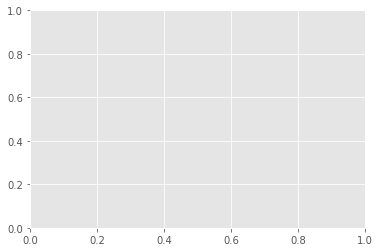

In [25]:
imgs = []
fig, ax = plt.subplots(1, 1)

0 0.0390249
1 0.0361846
2 0.0328923
3 0.0328195
4 0.0299846


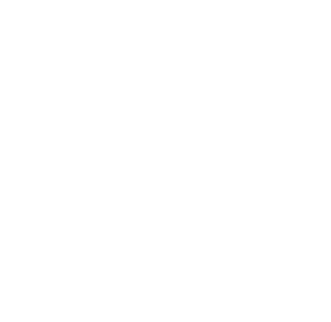

In [29]:
for epoch in range (nb_epochs):
    for batch_X, _ in ds.train.next_batch():
        sess.run(optimizer, feed_dict={X: batch_X - mean_img})
    
    reconstruction = sess.run(Y, feed_dict={X: examples - mean_img})
    reconstruction = (reconstruction + mean_img).reshape(-1, 28, 28)
    reconstruction = np.clip(reconstruction, 0, 255)
    
    img_i = montage(reconstruction).astype(np.uint8)
    imgs.append(img_i)
    
    ax.imshow(img_i, cmap='gray')
    fig.canvas.draw()
    
    print (epoch, sess.run(cost, feed_dict={X: batch_X - mean_img}))

gif.build_gif(imgs, saveto='ae2.gif', cmap='gray')

In [30]:
ipyd.Image(url='ae2.gif?{}'.format(np.random.rand()),
           height=500, width=500)

# All aboard the Tensorboard

In [26]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [27]:
show_graph(tf.get_default_graph().as_graph_def())

# Convolutional Autoencoder

In [131]:
tf.reset_default_graph()

In [132]:
nb_features

784

In [133]:
X = tf.placeholder(tf.float32, (None, nb_features))

In [134]:
X_tensor = tf.reshape(X, [-1, 28,28,1])

In [135]:
nb_filters = [16, 16, 16]
filter_sizes = [4, 4, 4]

In [136]:
# Number of inputs is just one, corresponding to the one channel
nb_input = 1
current_input = X_tensor

Network = []
shapes = []

for i, nb_output in enumerate(nb_filters):
    with tf.variable_scope('encoder/layer/{}'.format(i)):
        print (current_input.get_shape())
        shapes.append(current_input.get_shape().as_list())
        
        W = tf.get_variable(
                name='W',
                shape=[
                    filter_sizes[i],
                    filter_sizes[i],
                    nb_input,
                    nb_output
                ],
                initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02)
            )
        
        h = tf.nn.conv2d(current_input, W, strides=[1,2,2,1], padding='SAME')
        
        current_input = tf.nn.relu(h)
        Network.append(W)
        
        nb_input = nb_output

(?, 28, 28, 1)
(?, 14, 14, 16)
(?, 7, 7, 16)


## Decoder

In [137]:
Network.reverse()
shapes.reverse()

nb_filters.reverse()
nb_filters = nb_filters[1:] + [1]

In [138]:
print(nb_filters, filter_sizes, shapes)

[16, 16, 1] [4, 4, 4] [[None, 7, 7, 16], [None, 14, 14, 16], [None, 28, 28, 1]]


In [139]:
for i, shape in enumerate(shapes):
    with tf.variable_scope('decoder/layer/{}'.format(i)):
        W = Network[i]
        h = tf.nn.conv2d_transpose(current_input, W, 
                  tf.stack([tf.shape(X)[0], shape[1], shape[2], shape[3]]),
                strides=[1, 2, 2, 1], padding='SAME'
                                  )
        current_input = tf.nn.relu(h)

In [140]:
current_input.get_shape()

TensorShape([Dimension(None), Dimension(None), Dimension(None), Dimension(None)])

In [141]:
Y = current_input
Y = tf.reshape(Y, [-1, nb_features])

In [142]:
Y.get_shape()

TensorShape([Dimension(None), Dimension(784)])

## Training

In [143]:
cost = tf.reduce_mean(tf.reduce_mean(tf.squared_difference(X, Y), 1))
learning_rate = 0.001

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [144]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [145]:
batch_size = 100
nb_epochs = 5

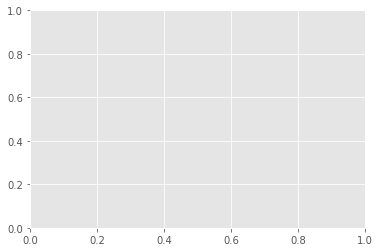

In [146]:
examples = ds.X[:100]
imgs = []
fig, ax = plt.subplots(1,1)

0 0.024479
1 0.0241208
2 0.0234954
3 0.0245349
4 0.0249412


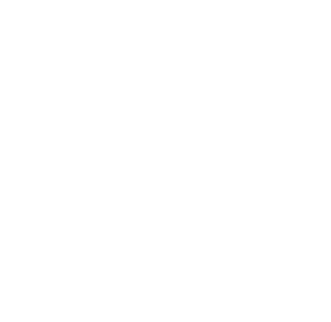

In [152]:
for epoch in range (nb_epochs):
    for batch_X, _ in ds.train.next_batch():
        sess.run(optimizer, feed_dict={X: batch_X - mean_img})
    
    reconstruction = sess.run(Y, feed_dict={X: examples - mean_img})
    reconstruction = (reconstruction + mean_img).reshape(-1, 28, 28)
    reconstruction = np.clip(reconstruction, 0, 255)
    
    img_i = montage(reconstruction).astype(np.uint8)
    imgs.append(img_i)
    
    ax.imshow(img_i, cmap='gray')
    fig.canvas.draw()
    
    print (epoch, sess.run(cost, feed_dict={X: batch_X - mean_img}))

gif.build_gif(imgs, saveto='conv-ae.gif', cmap='gray')

In [153]:
ipyd.Image(url='conv-ae.gif?{}'.format(np.random.rand()),
           height=500, width=500)

# Variational Autoencoder

In [159]:
from libs import vae

In [162]:
dir(vae)

['CELEB',
 'MNIST',
 'VAE',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'batch_norm',
 'create_input_pipeline',
 'np',
 'os',
 'test_celeb',
 'test_mnist',
 'test_sita',
 'tf',
 'train_vae',
 'utils']

In [163]:
vae.test_mnist()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
train: 69.3283904484 valid: 49.3217508589
train: 42.8941364152 valid: 42.3603597369
train: 40.1244548389 valid: 41.1804930551
train: 38.673913547 valid: 40.418523734
train: 37.9347549847 valid: 40.0463033404
train: 37.4266753742 valid: 38.0858288356
train: 37.2618386132 valid: 40.0652015686
train: 36.8165155683 valid: 38.3352161952
train: 36.4650317601 valid: 36.7396100725
train: 36.3465798923 valid: 38.0833109174


In [ ]:
vae.test_celeb()

In [170]:
ipyd.Image(url='./manifold_00000279.png?{}'.format(np.random.rand()),
           height=5000, width=5000)

In [165]:
ipyd.Image(url='./reconstruction_00000279.png'.format(np.random.rand()),
           height=500, width=500)

# Predicting Labels

In [182]:
tf.reset_default_graph()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


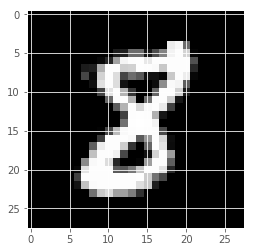

In [183]:
ds = datasets.MNIST(one_hot=True)
plt.figure()
plt.imshow(np.reshape(ds.X[0], (28, 28)), cmap='gray')
print(ds.Y[0])

In [184]:
print(ds.X.shape)
print(ds.Y.shape)

(70000, 784)
(70000, 10)


## Split the dataset

In [185]:
ds = datasets.MNIST(split=[0.8, 0.1, 0.1])

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [186]:
n_input = 28 * 28
n_output = 10

In [187]:
X = tf.placeholder(tf.float32, [None, n_input])
Y = tf.placeholder(tf.float32, [None, n_output])

In [188]:
from libs import utils

Y_pred, W = utils.linear(
    x=X,
    n_output=n_output,
    activation=tf.nn.softmax,
    name='layer1')

In [189]:
cross_entropy = -tf.reduce_sum(Y * tf.log(Y_pred + 1e-12))
optimizer = tf.train.AdamOptimizer(0.001).minimize(cross_entropy)

In [190]:
predicted_y = tf.argmax(Y_pred, 1)
actual_y = tf.argmax(Y, 1)

In [191]:
correct_prediction = tf.equal(predicted_y, actual_y)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

## Training

In [192]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Now actually do some training:
batch_size = 50
n_epochs = 5
for epoch_i in range(n_epochs):
    for batch_xs, batch_ys in ds.train.next_batch():
        sess.run(optimizer, feed_dict={
            X: batch_xs,
            Y: batch_ys
        })
    valid = ds.valid
    print(sess.run(accuracy,
                   feed_dict={
                       X: valid.images,
                       Y: valid.labels
                   }))

# Print final test accuracy:
test = ds.test
print(sess.run(accuracy,
               feed_dict={
                   X: test.images,
                   Y: test.labels
               }))

0.898857
0.912714
0.917571
0.921571
0.922429
0.916429


## Inspect the graph

In [193]:
# We first get the graph that we used to compute the network
g = tf.get_default_graph()

# And can inspect everything inside of it
[op.name for op in g.get_operations()]

['Placeholder',
 'Placeholder_1',
 'layer1/W/Initializer/random_uniform/shape',
 'layer1/W/Initializer/random_uniform/min',
 'layer1/W/Initializer/random_uniform/max',
 'layer1/W/Initializer/random_uniform/RandomUniform',
 'layer1/W/Initializer/random_uniform/sub',
 'layer1/W/Initializer/random_uniform/mul',
 'layer1/W/Initializer/random_uniform',
 'layer1/W',
 'layer1/W/Assign',
 'layer1/W/read',
 'layer1/b/Initializer/Const',
 'layer1/b',
 'layer1/b/Assign',
 'layer1/b/read',
 'layer1/MatMul',
 'layer1/h',
 'layer1/Softmax',
 'add/y',
 'add',
 'Log',
 'mul',
 'Const',
 'Sum',
 'Neg',
 'gradients/Shape',
 'gradients/Const',
 'gradients/Fill',
 'gradients/Neg_grad/Neg',
 'gradients/Sum_grad/Reshape/shape',
 'gradients/Sum_grad/Reshape',
 'gradients/Sum_grad/Shape',
 'gradients/Sum_grad/Tile',
 'gradients/mul_grad/Shape',
 'gradients/mul_grad/Shape_1',
 'gradients/mul_grad/BroadcastGradientArgs',
 'gradients/mul_grad/mul',
 'gradients/mul_grad/Sum',
 'gradients/mul_grad/Reshape',
 'grad

In [196]:
show_graph(tf.get_default_graph().as_graph_def())

## Computing tensor from operation

In [197]:
W = g.get_tensor_by_name('layer1/W:0')
W_arr = np.array(W.eval(session=sess))
print(W_arr.shape) 

(784, 10)


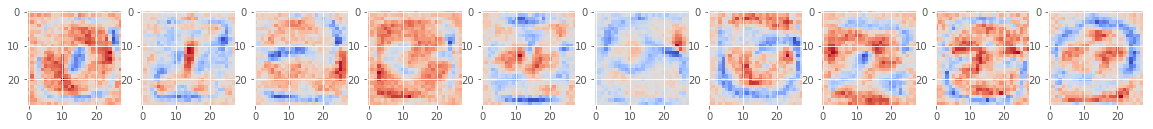

In [199]:
fig, ax = plt.subplots(1, 10, figsize=(20, 3))

for i in range(10):
    ax[i].imshow(W_arr[:, i].reshape((28, 28)), cmap='coolwarm')

# Convolutional Neural Network

In [200]:
from tensorflow.python.framework.ops import reset_default_graph
reset_default_graph()

In [201]:
ds = datasets.MNIST(one_hot=True, split=[0.8, 0.1, 0.1])
X = tf.placeholder(tf.float32, [None, 784])
Y = tf.placeholder(tf.float32, [None, 10])

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [202]:
X_tensor = tf.reshape(X, [-1, 28, 28, 1])

In [203]:
filter_size = 5
n_filters_in = 1
n_filters_out = 32
W_1 = tf.get_variable(
    name='W',
    shape=[filter_size, filter_size, n_filters_in, n_filters_out],
    initializer=tf.random_normal_initializer())

In [204]:
b_1 = tf.get_variable(
    name='b',
    shape=[n_filters_out],
    initializer=tf.constant_initializer())

In [205]:
h_1 = tf.nn.relu(
    tf.nn.bias_add(
        tf.nn.conv2d(input=X_tensor,
                     filter=W_1,
                     strides=[1, 2, 2, 1],
                     padding='SAME'),
        b_1))

And the second layer

In [206]:
n_filters_in = 32
n_filters_out = 64
W_2 = tf.get_variable(
    name='W2',
    shape=[filter_size, filter_size, n_filters_in, n_filters_out],
    initializer=tf.random_normal_initializer())
b_2 = tf.get_variable(
    name='b2',
    shape=[n_filters_out],
    initializer=tf.constant_initializer())
h_2 = tf.nn.relu(
    tf.nn.bias_add(
        tf.nn.conv2d(input=h_1,
                 filter=W_2,
                 strides=[1, 2, 2, 1],
                 padding='SAME'),
        b_2))

In [207]:
# We'll now reshape so we can connect to a fully-connected/linear layer:
h_2_flat = tf.reshape(h_2, [-1, 7 * 7 * n_filters_out])

In [208]:
# NOTE: This uses a slightly different version of the linear function than the lecture!
h_3, W = utils.linear(h_2_flat, 128, activation=tf.nn.relu, name='fc_1')

In [209]:
Y_pred, W = utils.linear(h_3, n_output, activation=tf.nn.softmax, name='fc_2')

## Training the network

In [210]:
cross_entropy = -tf.reduce_sum(Y * tf.log(Y_pred + 1e-12))
optimizer = tf.train.AdamOptimizer().minimize(cross_entropy)

In [211]:
correct_prediction = tf.equal(tf.argmax(Y_pred, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

In [212]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [213]:
batch_size = 50
n_epochs = 10
for epoch_i in range(n_epochs):
    for batch_xs, batch_ys in ds.train.next_batch():
        sess.run(optimizer, feed_dict={
            X: batch_xs,
            Y: batch_ys
        })
    valid = ds.valid
    print(sess.run(accuracy,
                   feed_dict={
                       X: valid.images,
                       Y: valid.labels
                   }))

# Print final test accuracy:
test = ds.test
print(sess.run(accuracy,
               feed_dict={
                   X: test.images,
                   Y: test.labels
               }))

0.410714
0.480714
0.682429
0.959143
0.968
0.972571
0.975
0.976429
0.976857
0.972857
0.967571


## Inspecting the kernals

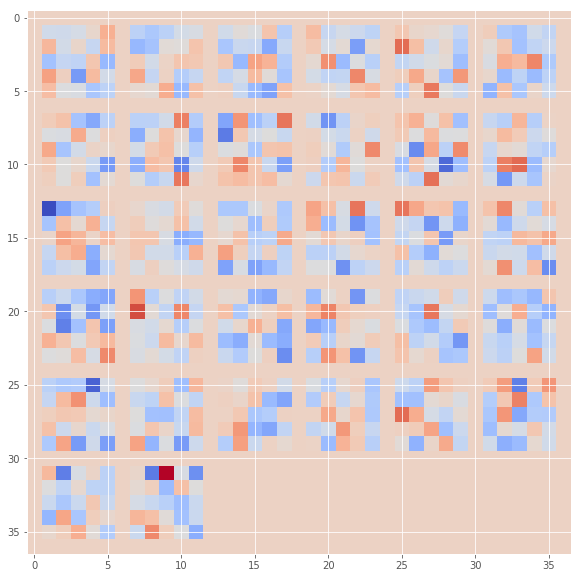

In [215]:
from libs.utils import montage_filters
W1 = sess.run(W_1)
plt.figure(figsize=(10, 10))
plt.imshow(montage_filters(W1), cmap='coolwarm', interpolation='nearest')

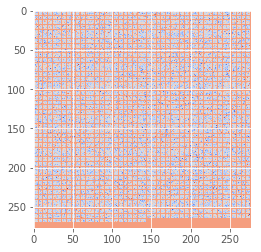

In [216]:
W2 = sess.run(W_2)
plt.imshow(montage_filters(W2 / np.max(W2)), cmap='coolwarm')

# Saving Models

## Checkpoint

Creating a checkpoint requires you to have already created a set of operations in your tensorflow graph. Once you've done this, you'll create a session like normal and initialize all of the variables. After this, you create a tf.train.Saver which can restore a previously saved checkpoint, overwriting all of the variables with your saved parameters.

In [217]:
import os

sess = tf.Session()
init_op = tf.global_variables_initializer()
saver = tf.train.Saver()
sess.run(init_op)

In [218]:
# Save Model
save_path = saver.save(sess, "./model.ckpt")
print("Model saved in file: %s" % save_path)

Model saved in file: ./model.ckpt


In [221]:
# Restore model
if os.path.exists("./model.ckpt"):
    saver.restore(sess, "model.ckpt")
    print("Model restored.")

## Protobuf

Production line stuff. No code to generate model and other irrelevant stuff.

In [ ]:
path='./'
ckpt_name = './model.ckpt'
fname = 'model.tfmodel'
dst_nodes = ['Y']
g_1 = tf.Graph()
with tf.Session(graph=g_1) as sess:
    x = tf.placeholder(tf.float32, shape=(1, 224, 224, 3))
    # Replace this with some code which will create your tensorflow graph:
    net = create_network()
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, ckpt_name)
    graph_def = tf.python.graph_util.convert_variables_to_constants(
        sess, sess.graph_def, dst_nodes)
g_2 = tf.Graph()
with tf.Session(graph=g_2) as sess:
    tf.train.write_graph(
        tf.python.graph_util.extract_sub_graph(
            graph_def, dst_nodes), path, fname, as_text=False)

In [ ]:
# Import and restore

with open("model.tfmodel", mode='rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

tf.import_graph_def(net['graph_def'], name='model')